In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [29]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
Lv_water = 2.26*10**3 # J g-1 -- latent heat of vaporization for water
entrainment = 0.1

In [30]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
pmax_array = nc_open_compile(file_years,"pmax")
tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10))[:,0]
tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (pmax_array >= np.percentile(pmax_array,75)) )[:,0]
print(tropical_indx.shape)
print(tropical_rain_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_rain_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_rain_indx]
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_rain_indx]

(408655,)
(124047,)


In [31]:
# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI_all = negative_to_nan(qv_array)[tropical_indx]
qv_ERAI = negative_to_nan(qv_array)[tropical_rain_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI_all = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_rain_indx]
qvsat_ERAI_all = eps * satVapP_liq(temp_ERAI_all) / ( plev_ERAI - satVapP_liq(temp_ERAI_all) )
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

In [32]:
# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
print(qvsat_ERAI.shape,qvsat_ERAI_all.shape)
sd850_ERAI_all = (qvsat_ERAI_all[:,i] - qv_ERAI_all[:,i])*1000
i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd700_ERAI_all = (qvsat_ERAI_all[:,i] - qv_ERAI_all[:,i])*1000
i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd550_ERAI_all = (qvsat_ERAI_all[:,i] - qv_ERAI_all[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3
sd_ERAI_all = (sd850_ERAI_all + sd700_ERAI_all + sd550_ERAI_all)/3

(124047, 32) (408655, 32)


In [33]:
upp = np.percentile( rad_ERAI, 75 )
loo = np.percentile( rad_ERAI, 25 )

qv_small = qv_ERAI[np.where(rad_ERAI <= loo),:][0]
qv_large = qv_ERAI[np.where(rad_ERAI >= upp),:][0]
qvsat_small = qvsat_ERAI[np.where(rad_ERAI <= loo),:][0]
qvsat_large = qvsat_ERAI[np.where(rad_ERAI >= upp),:][0]
temp_small = temp_ERAI[np.where(rad_ERAI <= loo),:][0]
temp_large = temp_ERAI[np.where(rad_ERAI >= upp),:][0]

In [73]:
upp = np.percentile( sd_ERAI, 75 )
loo = np.percentile( sd_ERAI, 25 )

qv_lowsd = qv_ERAI[np.where(sd_ERAI <= loo),:][0]
qv_highsd = qv_ERAI[np.where(sd_ERAI >= upp),:][0]
qvsat_lowsd = qvsat_ERAI[np.where(sd_ERAI <= loo),:][0]
qvsat_highsd = qvsat_ERAI[np.where(sd_ERAI >= upp),:][0]
temp_lowsd = temp_ERAI[np.where(sd_ERAI <= loo),:][0]
temp_highsd = temp_ERAI[np.where(sd_ERAI >= upp),:][0]

#buoy_lowsd = entrainment*Lv_water*(qvsat_lowsd - qv_lowsd)
#buoy_highsd = entrainment*Lv_water*(qvsat_highsd - qv_highsd)
buoy_ERAI = entrainment*Lv_water*(qvsat_ERAI - qv_ERAI)
buoy_ERAI_all = entrainment*Lv_water*(qvsat_ERAI_all - qv_ERAI_all)

buoy_lowsd2 = entrainment*Lv_water*(np.nanmedian(qvsat_ERAI,0) - np.nanmedian(qv_lowsd,0))
buoy_highsd2 = entrainment*Lv_water*(np.nanmedian(qvsat_ERAI,0) - np.nanmedian(qv_highsd,0))
buoy_lowsd = entrainment*Lv_water*(np.nanmedian(qvsat_lowsd,0) - np.nanmedian(qv_lowsd,0))
buoy_highsd = entrainment*Lv_water*(np.nanmedian(qvsat_highsd,0) - np.nanmedian(qv_highsd,0))
buoy_lowsd99 = entrainment*Lv_water*(np.nanpercentile(qvsat_lowsd - qv_lowsd,99,axis=0))
buoy_highsd99 = entrainment*Lv_water*(np.nanpercentile(qvsat_highsd - qv_highsd,99,axis=0))

buoy_small = entrainment*Lv_water*(np.nanmedian(qvsat_small,0) - np.nanmedian(qv_small,0))
buoy_small3 = 1.25*entrainment*Lv_water*(np.nanmedian(qvsat_small,0) - np.nanmedian(qv_small,0))
buoy_large = entrainment*Lv_water*(np.nanmedian(qvsat_large,0) - np.nanmedian(qv_large,0))
buoy_small2 = entrainment*Lv_water*(np.nanmedian(qvsat_ERAI,0) - np.nanmedian(qv_small,0))
buoy_large2 = entrainment*Lv_water*(np.nanmedian(qvsat_ERAI,0) - np.nanmedian(qv_large,0))
buoy_small99 = entrainment*Lv_water*(np.nanpercentile(qvsat_small-qv_small,99,axis=0))
buoy_large99 = entrainment*Lv_water*(np.nanpercentile(qvsat_large-qv_large,99,axis=0))

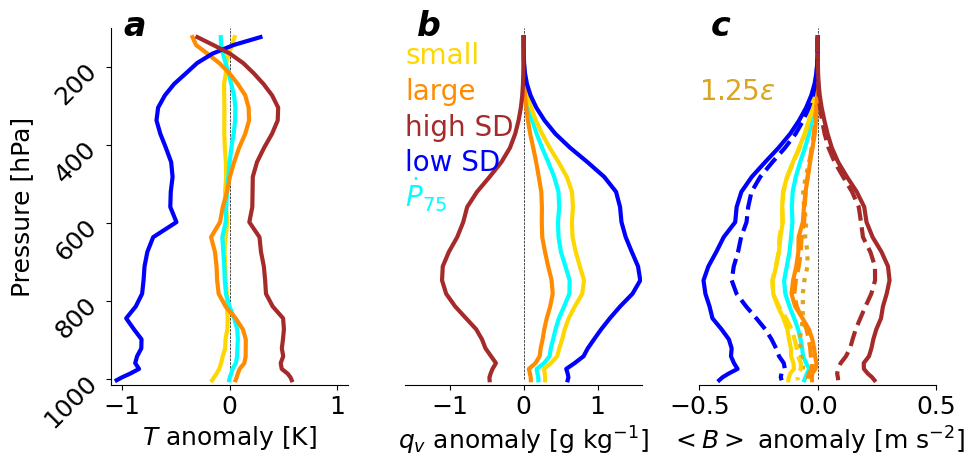

In [76]:
fig, ax = plt.subplots( 1, 3, figsize =(10, 5) )
let = [ 'a', 'b', 'c', 'd' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    #axis.set( ylabel = ylab[i] )
    axis.set_ylim( [1013, 100])
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.text( 0.05, 0.98, let[i], style='italic', weight='bold', fontsize=font_size+6, transform=axis.transAxes )
    if i !=0:
        axis.spines['left'].set_visible( False )
        axis.set_yticklabels([])
        axis.set_yticks([])
    if i == 0:
        mt = np.nanmedian(temp_ERAI_all,axis=0)
        axis.plot( [0,0], [1000,100], lw=0.5, ls='--', color='k' )
        axis.plot( np.nanmedian(temp_small,axis=0) - mt, plev_ERAI/100., color='gold', lw=3 )
        axis.plot( np.nanmedian(temp_ERAI,axis=0) - mt, plev_ERAI/100., color='cyan', lw=3 )
        axis.plot( np.nanmedian(temp_large,axis=0) - mt, plev_ERAI/100., color='darkorange', lw=3 )
        axis.plot( np.nanmedian(temp_lowsd,axis=0) - mt, plev_ERAI/100., color='blue', lw=3 )
        axis.plot( np.nanmedian(temp_highsd,axis=0) - mt, plev_ERAI/100., color='brown', lw=3 )
        axis.set_xlabel( r'$T$ anomaly [K]', fontsize=font_size )
        axis.set_xlim([-1.1, 1.1])
        axis.tick_params( axis='y', labelrotation=45 )
        axis.set_ylabel( 'Pressure [hPa]', fontsize=font_size )
    if i == 1:
        axis.plot( [0,0], [1000,100], lw=0.5, ls='--', color='k' )
        mqv = np.nanmedian(qv_ERAI_all,axis=0)
        axis.plot( (np.nanmedian(qv_ERAI,axis=0) - mqv)*1000., plev_ERAI/100., color='cyan', lw=3 )
        axis.plot( (np.nanmedian(qv_small,axis=0) - mqv)*1000., plev_ERAI/100., color='gold', lw=3 )
        axis.plot( (np.nanmedian(qv_large,axis=0) - mqv)*1000, plev_ERAI/100., color='darkorange', lw=3 )
        axis.plot( (np.nanmedian(qv_lowsd,axis=0) - mqv)*1000, plev_ERAI/100., color='blue', lw=3 )
        axis.plot( (np.nanmedian(qv_highsd,axis=0) - mqv)*1000, plev_ERAI/100., color='brown', lw=3 )
        axis.set_xlabel( r'$q_v$ anomaly [g kg$^{-1}$]', fontsize=font_size )
        axis.set_xlim([-1.6, 1.6])
        axis.text( 0, 0.5, r'$\dot{P}_{75}$', color='cyan', fontsize=font_size+2, transform=axis.transAxes )
        axis.text( 0, 0.6, 'low SD', color='blue', fontsize=font_size+2, transform=axis.transAxes )
        axis.text( 0, 0.7, 'high SD', color='brown', fontsize=font_size+2, transform=axis.transAxes )
        axis.text( 0, 0.8, 'large', color='darkorange', fontsize=font_size+2, transform=axis.transAxes )
        axis.text( 0, 0.9, 'small', color='gold', fontsize=font_size+2, transform=axis.transAxes )
    if i == 2:
        axis.plot( [0,0], [1000,100], lw=0.5, ls='--', color='k' )
        mbuoy = np.nanmedian(buoy_ERAI_all,axis=0)
        axis.plot( (np.nanmedian(buoy_ERAI,axis=0) - mbuoy), plev_ERAI/100., color='cyan', lw=3 )
        axis.plot( (buoy_small - mbuoy), plev_ERAI/100., color='gold', lw=3 )
        axis.plot( (buoy_small3 - mbuoy), plev_ERAI/100., color='goldenrod', lw=3, ls=':' )
        axis.plot( (buoy_large - mbuoy), plev_ERAI/100., color='darkorange', lw=3 )
        axis.plot( (buoy_small2 - mbuoy), plev_ERAI/100., color='gold', lw=3, ls='--' )
        axis.plot( (buoy_large2 - mbuoy), plev_ERAI/100., color='darkorange', lw=3, ls='--' )
        
        axis.plot( (buoy_lowsd - mbuoy), plev_ERAI/100., color='blue', lw=3 )
        axis.plot( (buoy_highsd - mbuoy), plev_ERAI/100., color='brown', lw=3 )
        axis.plot( (buoy_lowsd2 - mbuoy), plev_ERAI/100., color='blue', lw=3, ls='--' )
        axis.plot( (buoy_highsd2 - mbuoy), plev_ERAI/100., color='brown', lw=3, ls='--' )
        axis.set_xlabel( r'$<B>$ anomaly [m s$^{-2}$]', fontsize=font_size )
        axis.text( 0, 0.8, r'1.25$\epsilon$', color='goldenrod', fontsize=font_size+2, transform=axis.transAxes )
        axis.set_xlim([-0.5, 0.5])
        
plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/qv-T-buoy-profiles.pdf', bbox_inches='tight' )
plt.show()

In [ ]:
    if i == 0:
        mcsf = np.nanmedian(qv_ERAI_all/qvsat_ERAI_all,axis=0)*100.
        axis.plot( [0,0], [1000,100], lw=0.5, ls='--', color='k' )
        axis.plot( np.nanmedian(qv_ERAI/qvsat_ERAI,axis=0)*100.-mcsf, plev_ERAI/100., color='cyan', lw=3 )
        axis.plot( np.nanmedian(qv_small/qvsat_small,axis=0)*100. - mcsf, plev_ERAI/100., color='gold', lw=3 )
        axis.plot( np.nanmedian(qv_large/qvsat_large,axis=0)*100. - mcsf, plev_ERAI/100., color='darkorange', lw=3 )
        axis.plot( np.nanmedian(qv_lowsd/qvsat_lowsd,axis=0)*100. - mcsf, plev_ERAI/100., color='blue', lw=2 )
        axis.plot( np.nanmedian(qv_highsd/qvsat_highsd,axis=0)*100. - mcsf, plev_ERAI/100., color='brown', lw=2 )
        axis.set_xlabel( 'CSF anomaly [%]', fontsize=font_size )
        axis.tick_params( axis='y', labelrotation=45 )
        axis.set_ylabel( 'Pressure [hPa]', fontsize=font_size )
        axis.set_xlim([-33,33])

In [ ]:
    if i == 3:
        axis.plot( [0,0], [1000,100], lw=0.5, ls='--', color='k' )
        mbuoy = np.nanpercentile(buoy_ERAI_all,99,axis=0)
        axis.plot( (np.nanpercentile(buoy_ERAI,99,axis=0) - mbuoy), plev_ERAI/100., color='cyan', lw=3 )
        axis.plot( (buoy_small99 - mbuoy), plev_ERAI/100., color='gold', lw=3 )
        axis.plot( (buoy_large99 - mbuoy), plev_ERAI/100., color='darkorange', lw=3 )
        #axis.plot( (buoy_small2 - mbuoy), plev_ERAI/100., color='gold', lw=3, ls='--' )
        #axis.plot( (buoy_large2 - mbuoy), plev_ERAI/100., color='darkorange', lw=3, ls='--' )
        
        axis.plot( (buoy_lowsd99 - mbuoy), plev_ERAI/100., color='blue', lw=3 )
        axis.plot( (buoy_highsd99 - mbuoy), plev_ERAI/100., color='brown', lw=3 )
        #axis.plot( (buoy_lowsd2 - mbuoy), plev_ERAI/100., color='blue', lw=3, ls='--' )
        #axis.plot( (buoy_highsd2 - mbuoy), plev_ERAI/100., color='brown', lw=3, ls='--' )
        axis.set_xlabel( r'$B_{99}$ anomaly [m s$^{-2}$]', fontsize=font_size )
        axis.set_xlim([-1, 1])